Classification MNIST

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
X, y = mnist["data"], mnist["target"]

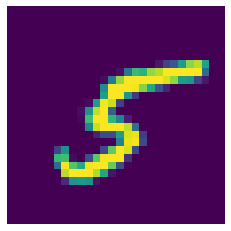

70000

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

digit = X[2363]
image = digit.reshape(28,28)
plt.imshow(image, cmap = matplotlib.cm.viridis,
interpolation="nearest")
plt.axis("off")
plt.show()
len(X)

Aprox un 90% para train 10% para test

In [3]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Permutamos los indices

In [4]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

Seleccionamos solamente los que son 5 (haremos un clasificador de 5s)

In [5]:
#5 detector
y_train = y_train.astype(np.int8)
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)


In [6]:
from sklearn.linear_model import SGDClassifier #stochastic gradient descent

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([digit])

array([ True])

In [7]:
sgd_clf.predict([X_test[234]])

array([False])

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints 0.9502, 0.96565 and 0.96495

0.9367
0.95425
0.9659


In [9]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9367 , 0.95425, 0.9659 ])

Importancia de no usar accuracy como medidor de rendimiento
Un modelo que siempre predice que no es un 5 tambien tendra un 90% de accuracy

In [10]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1), dtype=bool)

never5clf = Never5Classifier()
cross_val_score(never5clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.91205, 0.9075 , 0.9094 ])

In [11]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [12]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5,y_train_pred)

array([[52689,  1890],
       [  973,  4448]], dtype=int64)

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(precision_score(y_train_5,y_train_pred))
print(recall_score(y_train_5,y_train_pred))
print(f1_score(y_train_5, y_train_pred))

0.7017986746607763
0.8205128205128205
0.7565269155540436


In [14]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
method="decision_function")

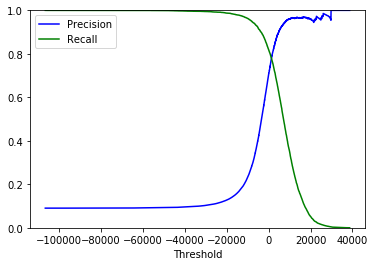

In [15]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b-", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [16]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [17]:
from sklearn.metrics import roc_curve 
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

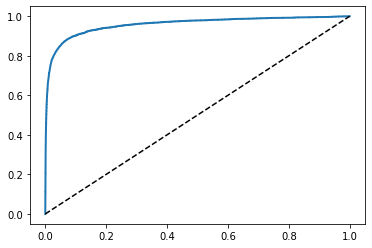

In [18]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
plot_roc_curve(fpr, tpr)
plt.show()


In [19]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9581811078457547

In [20]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probar_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

C:\Users\willw\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\willw\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\willw\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [21]:
y_scores_forest = y_probar_forest[:,1]
fpr_forest, tpr_forest, tresholds_forest = roc_curve(y_train_5, y_scores_forest)

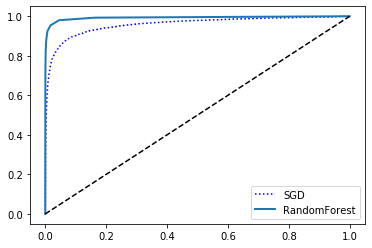

In [22]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "RandomForest")
plt.legend(loc="lower right")
plt.show()

In [23]:
roc_auc_score(y_train_5, y_scores_forest)

0.9928050709798533

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

In [25]:
from sklearn.svm import SVC
svc_clf = SVC()
svc_clf.fit(X_train, y_train)
svc_clf.predict([digit])

C:\Users\willw\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([5], dtype=int8)

In [26]:
some_digit_scores = svc_clf.decision_function([digit])
some_digit_scores

array([[ 4.84284851,  2.7323054 ,  8.30302864,  7.28716065, -0.29085704,
         9.30829307,  2.73892447,  6.22791247,  0.69440407,  2.73022996]])

In [27]:
np.argmax(some_digit_scores)

5

In [28]:
svc_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [29]:
import winsound
frequency = 500  # Set Frequency To 2500 Hertz
duration = 700  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [30]:
from sklearn.linear_model import SGDClassifier #stochastic gradient descent
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [31]:
sgd_clf.predict([digit])

array([5], dtype=int8)

In [32]:
sgd_clf.decision_function([digit])

array([[ -823.43290122,  -962.95353133,  -406.44688364,  -638.59449924,
         -789.42412642,   476.66207148, -1488.34023231, -1000.13480766,
          311.32473552, -1358.92828572]])

In [33]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.90236953, 0.89524476, 0.89968495])

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

cross_val_predict(sgd_clf,X_train,y_train,cv=3)
confusion_matrix(y_train,y_train_pred)
print(precision_score(y_train_5,y_train_pred))
print(recall_score(y_train_5,y_train_pred))
print(f1_score(y_train_5, y_train_pred))

0.7017986746607763
0.8205128205128205
0.7565269155540436
